## 1. Install dependences and load data

In [21]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import cv2
import imghdr
import matplotlib
from PIL import Image
import random
import pickle
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from tensorflow.keras.models import Sequential # good with 1 input 1 output
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import load_model


Define functions that will be used later on

In [3]:
def plot_loss_accuracy(histo):

  """This function plots the results of a model"""
  fig, axs = plt.subplots(1, 2, figsize=(14, 5))

  # Plot loss
  axs[0].plot(histo.history['loss'], color='teal', label='loss')
  axs[0].plot(histo.history['val_loss'], color='orange', label='val_loss')
  axs[0].set_title('Loss', fontsize=20)
  axs[0].legend(loc='upper left')

  # Plot accuracy
  axs[1].plot(histo.history['accuracy'], color='teal', label='accuracy')
  axs[1].plot(histo.history['val_accuracy'], color='orange', label='val_accuracy')
  axs[1].set_title('Accuracy', fontsize=20)
  axs[1].legend(loc='upper left')

  plt.show()

In [4]:
# connect to drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


We load the date with pickle. We serialized these objects with pickle in the "data_prep" notebook.
I divided the two notebooks so that I can use 'run all' more convenientely here.

In [5]:
path = "/content/drive/MyDrive/ml_project/"

with open(os.path.join(path, "img_train.pickle"), "rb") as pickle_in:
  img_train = pickle.load(pickle_in)

with open(os.path.join(path, "label_train.pickle"), "rb") as pickle_in:
  label_train = pickle.load(pickle_in)

with open(os.path.join(path,"img_test.pickle"), "rb") as pickle_in:
  img_test = pickle.load(pickle_in)

with open(os.path.join(path, "label_test.pickle"), "rb") as pickle_in:
  label_test = pickle.load(pickle_in)


In [6]:
# Avoid OutOfMemory error | I do not have a GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
print(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Brief data visualization

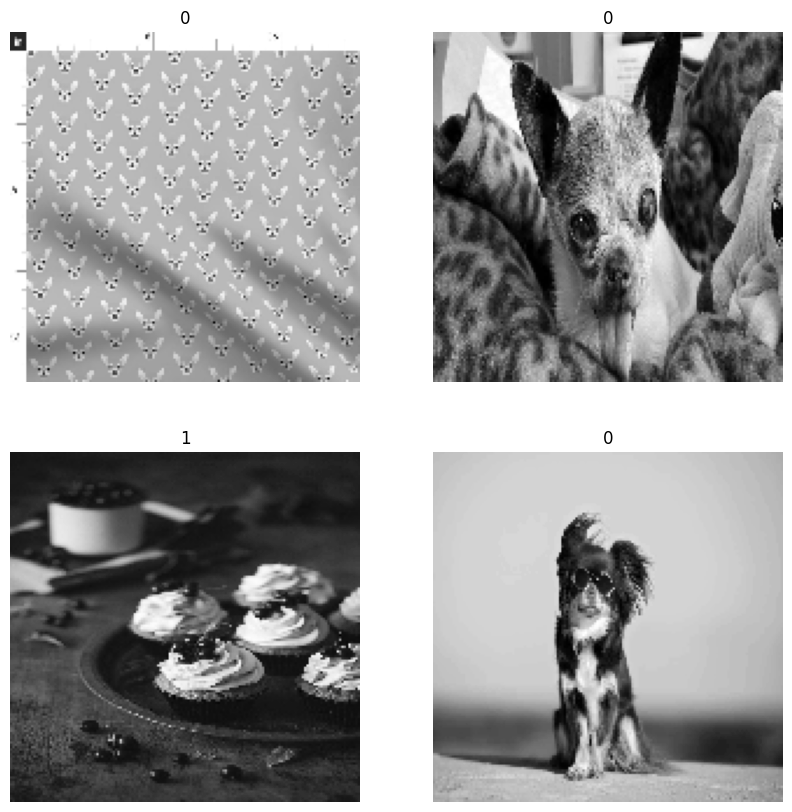

In [7]:
# Visualize images from training set
f, axarr = plt.subplots(2, 2, figsize=(10, 10))
im_index = 0

for row in range(2):
    for column in range(2):
        axarr[row, column].imshow(img_train[im_index], cmap='gray')
        axarr[row, column].axis("off")
        title = label_train[im_index]
        axarr[row,column].set_title(title) # add title to check correspondance
        im_index += 1

plt.show()

## Build the Model

In [24]:
# initialize the first model
model0 = Sequential()

# First layer must be input layer or have an input
model0.add(Conv2D(16, (3, 3), 1, activation='relu', input_shape=(150, 150, 1)))  # Change channels from 1 to 3 if using RGB instead of grayscale
# 16 is the number of filters, each filter is 3x3 pixels, 1 is the stride
model0.add(MaxPooling2D())
# This takes the maximum value after the ReLU and returns it
# Check MaxPooling2D?? for each 2x2 region (pool) takes the highest value

model0.add(Conv2D(32, (3, 3), 1, activation='relu'))  # Now 32 filters
model0.add(MaxPooling2D())

model0.add(Conv2D(64, (3, 3), 1, activation='relu'))
model0.add(MaxPooling2D())

model0.add(Flatten())
# When we apply the conv layer, the filters are going to be the last channel.
# We condense the length and width, then the number of filters will form the
# channel value. When we pass values to the dense layer, we don't want multiple
# values, but we want to 'flatten' them into a single value (thus the Flatten layer).

# Dense layers are fully connected layers
model0.add(Dense(256, activation='relu'))  # 256 values as output
model0.add(Dense(1, activation='sigmoid'))  # 1 output only, due to sigmoid

model0.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])
# we use binary cross entropy since it is a classification problem.
#tf.optimizers. to get all the optimizers

model0.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 148, 148, 16)      160       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 74, 74, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 36, 36, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_15 (Conv2D)          (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 17, 17, 64)       

## Train the model

In [25]:
#.fit method -> training component
#.predict -> when we make the predictions
hist0 = model0.fit(img_train,
                   label_train,
                   batch_size = 32,
                   epochs = 60,
                   validation_split = 0.15
                   )

# With this setup it takes way less to train the model
# Before I tried with tf.keras.utiles.image_from_dataset()
# with data uploaded to drive

Epoch 1/60
126/126 [==============================] - 4s 18ms/step - loss: 0.6332 - accuracy: 0.6383 - val_loss: 0.4711 - val_accuracy: 0.8042
Epoch 2/60
126/126 [==============================] - 2s 15ms/step - loss: 0.4924 - accuracy: 0.7706 - val_loss: 0.4169 - val_accuracy: 0.8239
Epoch 3/60
126/126 [==============================] - 2s 15ms/step - loss: 0.3990 - accuracy: 0.8225 - val_loss: 0.3789 - val_accuracy: 0.8479
Epoch 4/60
126/126 [==============================] - 2s 14ms/step - loss: 0.3240 - accuracy: 0.8620 - val_loss: 0.3781 - val_accuracy: 0.8479
Epoch 5/60
126/126 [==============================] - 2s 14ms/step - loss: 0.2426 - accuracy: 0.9045 - val_loss: 0.3806 - val_accuracy: 0.8338
Epoch 6/60
126/126 [==============================] - 2s 14ms/step - loss: 0.2008 - accuracy: 0.9160 - val_loss: 0.3600 - val_accuracy: 0.8634
Epoch 7/60
126/126 [==============================] - 2s 14ms/step - loss: 0.1471 - accuracy: 0.9423 - val_loss: 0.3943 - val_accuracy: 0.8521

Check Results of Model


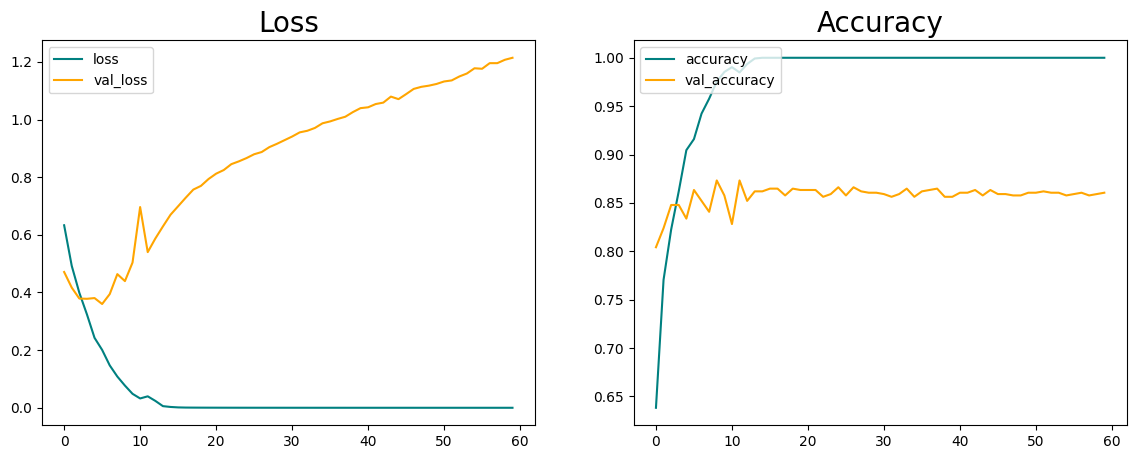

In [26]:
plot_loss_accuracy(hist0)

### Refine the model
The main issue is overfitting, we can try to solve the issue by adding Dropout or a BatchNormalization Layer. After doing this we move to the next model.

The dropout layer is applied on the dense layer before the ouput, using a value of p=0.5, following the methodology of Hinton(2012) (the paper where dropout was initially proposed.

However, according to (more) recent research (Park and Kwak, Analysis on the Dropout Effect in Convolutional Neural Networks), applying a lower level dropout (p=0.1) to convolutional layers can be beneficial.

However, according to some: "We must not use dropout layer after convolutional layer as we slide the filter over the width and height of the input image we produce a 2-dimensional activation map that gives the responses of that filter at every spatial position. So as dropout layer neutralizes (makes it zero) random neurons there are chances of loosing very important feature in an image in our training process." Pooja Sonkar (https://stats.stackexchange.com/users/215170/pooja-sonkar), Where should I place dropout layers in a neural network?, URL (version: 2018-10-05): https://stats.stackexchange.com/q/370325

In [27]:
# initialize the first model with dropout
model0d = Sequential()

model0d.add(Conv2D(16, (3, 3), 1, activation='relu', input_shape=(150, 150, 1)))  # Change channels from 1 to 3 if using RGB instead of grayscale
model0d.add(MaxPooling2D())

model0d.add(Conv2D(32, (3, 3), 1, activation='relu'))
model0d.add(MaxPooling2D())

model0d.add(Conv2D(64, (3, 3), 1, activation='relu'))
model0d.add(MaxPooling2D())

model0d.add(Flatten())

model0d.add(Dense(256, activation='relu'))
model0d.add(Dropout(0.5)) # we add dropout to reduce overfitting
model0d.add(Dense(1, activation='sigmoid'))

model0d.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

model0d.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 148, 148, 16)      160       
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 74, 74, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 36, 36, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_18 (Conv2D)          (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 17, 17, 64)       

Epoch 1/60
126/126 [==============================] - 4s 17ms/step - loss: 0.6495 - accuracy: 0.6371 - val_loss: 0.4953 - val_accuracy: 0.7634
Epoch 2/60
126/126 [==============================] - 2s 14ms/step - loss: 0.5031 - accuracy: 0.7681 - val_loss: 0.4516 - val_accuracy: 0.8141
Epoch 3/60
126/126 [==============================] - 2s 14ms/step - loss: 0.3965 - accuracy: 0.8277 - val_loss: 0.3778 - val_accuracy: 0.8408
Epoch 4/60
126/126 [==============================] - 2s 15ms/step - loss: 0.3473 - accuracy: 0.8489 - val_loss: 0.3522 - val_accuracy: 0.8451
Epoch 5/60
126/126 [==============================] - 2s 16ms/step - loss: 0.2542 - accuracy: 0.8968 - val_loss: 0.3735 - val_accuracy: 0.8310
Epoch 6/60
126/126 [==============================] - 2s 15ms/step - loss: 0.2152 - accuracy: 0.9115 - val_loss: 0.3507 - val_accuracy: 0.8606
Epoch 7/60
126/126 [==============================] - 2s 14ms/step - loss: 0.1590 - accuracy: 0.9369 - val_loss: 0.4246 - val_accuracy: 0.8169

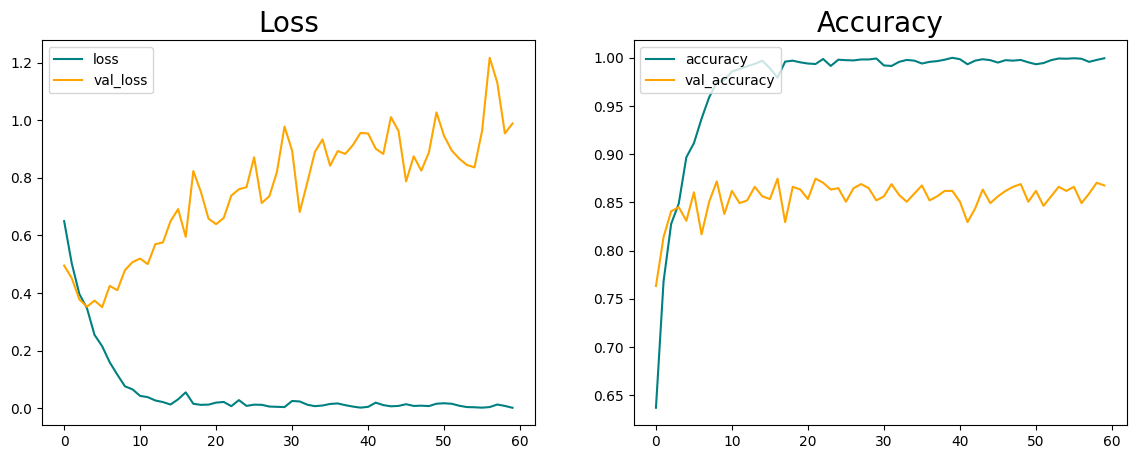

In [28]:
# get the history of the model with dropout

hist0d = model0d.fit(img_train,
                   label_train,
                   batch_size = 32,
                   epochs = 60,
                   validation_split = 0.15
                   )

plot_loss_accuracy(hist0d)

## Add L2 regularization
L2 regularization requires the addition of an extra term to the loss function of the network.

In [29]:
# Initialize the first model
model0_dl2 = Sequential()

# First layer must be input layer or have an input
model0_dl2.add(Conv2D(16, (3, 3), strides=1, activation='relu', input_shape=(150, 150, 1), kernel_regularizer=l2(0.01)))
model0_dl2.add(MaxPooling2D())


model0_dl2.add(Conv2D(32, (3, 3), strides=1, activation='relu', kernel_regularizer=l2(0.01)))
model0_dl2.add(MaxPooling2D())


model0_dl2.add(Conv2D(64, (3, 3), strides=1, activation='relu', kernel_regularizer=l2(0.01)))
model0_dl2.add(MaxPooling2D())


model0_dl2.add(Flatten())
model0_dl2.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
model0_dl2.add(Dropout(0.5))

model0_dl2.add(Dense(1, activation='sigmoid'))  # 1 output only, due to sigmoid

model0_dl2.compile(optimizer='adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

model0_dl2.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 148, 148, 16)      160       
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 74, 74, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_20 (Conv2D)          (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 36, 36, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_21 (Conv2D)          (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 17, 17, 64)       

Epoch 1/60
126/126 [==============================] - 4s 18ms/step - loss: 1.2648 - accuracy: 0.6197 - val_loss: 0.7426 - val_accuracy: 0.7887
Epoch 2/60
126/126 [==============================] - 2s 15ms/step - loss: 0.7224 - accuracy: 0.7069 - val_loss: 0.6678 - val_accuracy: 0.7831
Epoch 3/60
126/126 [==============================] - 2s 14ms/step - loss: 0.6744 - accuracy: 0.7313 - val_loss: 0.6211 - val_accuracy: 0.8099
Epoch 4/60
126/126 [==============================] - 2s 15ms/step - loss: 0.6425 - accuracy: 0.7537 - val_loss: 0.5645 - val_accuracy: 0.8127
Epoch 5/60
126/126 [==============================] - 2s 16ms/step - loss: 0.6130 - accuracy: 0.7611 - val_loss: 0.5760 - val_accuracy: 0.7901
Epoch 6/60
126/126 [==============================] - 2s 15ms/step - loss: 0.6064 - accuracy: 0.7686 - val_loss: 0.5449 - val_accuracy: 0.8183
Epoch 7/60
126/126 [==============================] - 2s 14ms/step - loss: 0.6099 - accuracy: 0.7646 - val_loss: 0.5461 - val_accuracy: 0.8211

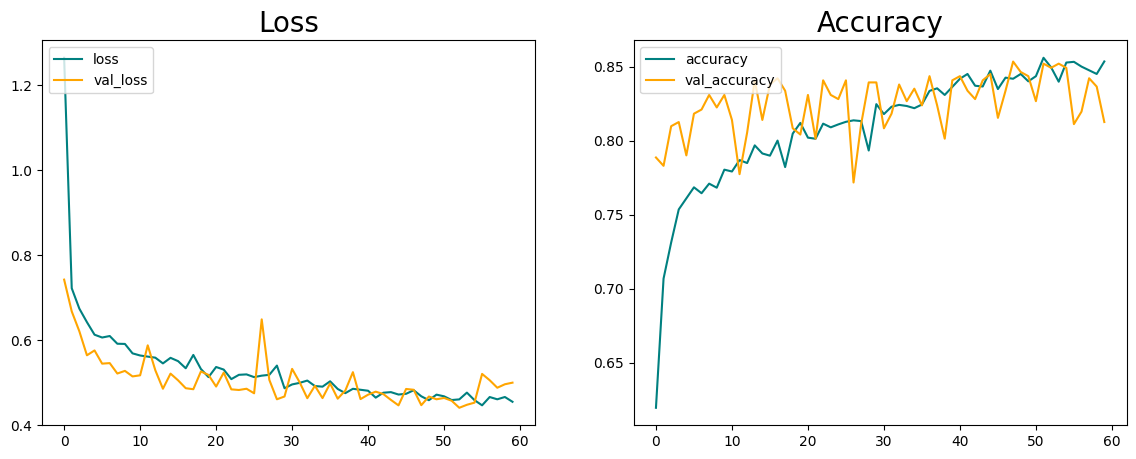

In [30]:
# get the history of the model with dropout

hist0_dl2 = model0_dl2.fit(
    img_train,
    label_train,
    batch_size = 32,
    epochs = 60,
    validation_split = 0.15
    )

plot_loss_accuracy(hist0_dl2)

## Evaluate Performance 1st model

The loss decreases steadily over time. However, while initially the validation loss decreases, around the 6th epoch it starts to increaase. This pattern possibly conveys overfitting of our algorithm. To improve this result we may need to apply regularization.

In [31]:
# To use the metrics we need to establish instances of them
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [32]:
print(f"Precision: {pre.result():.2f}, Recall: {re.result():.2f}, Accuracy: {acc.result():.2f}")

Precision: 0.00, Recall: 0.00, Accuracy: 0.00


## Second model
A second fancier model must be designed. How do I do it? I don't know.

In [47]:
# Initialize the model
model1 = Sequential()

model1.add(Conv2D(16, (3, 3), strides=1, activation='relu', input_shape=(150, 150, 1)))
model1.add(MaxPooling2D())


model1.add(Conv2D(32, (3, 3), strides=1, activation='relu'))

model1.add(MaxPooling2D())


model1.add(Conv2D(64, (3, 3), strides=1, activation='relu'))
model1.add(MaxPooling2D())


model1.add(Conv2D(128, (3, 3), strides=1, activation='relu'))
model1.add(MaxPooling2D())


model1.add(Flatten())

model1.add(Dense(256, activation='relu', ))
model1.add(Dropout(0.5))
model1.add(Dense(1, activation='sigmoid'))

model1.compile(optimizer='adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

model1.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_46 (Conv2D)          (None, 148, 148, 16)      160       
                                                                 
 max_pooling2d_45 (MaxPooli  (None, 74, 74, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_47 (Conv2D)          (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_46 (MaxPooli  (None, 36, 36, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_48 (Conv2D)          (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_47 (MaxPooli  (None, 17, 17, 64)      

Epoch 1/60
126/126 [==============================] - 5s 25ms/step - loss: 0.6787 - accuracy: 0.5807 - val_loss: 0.5806 - val_accuracy: 0.7141
Epoch 2/60
126/126 [==============================] - 3s 23ms/step - loss: 0.5341 - accuracy: 0.7405 - val_loss: 0.5223 - val_accuracy: 0.7324
Epoch 3/60
126/126 [==============================] - 2s 17ms/step - loss: 0.4849 - accuracy: 0.7775 - val_loss: 0.4397 - val_accuracy: 0.8127
Epoch 4/60
126/126 [==============================] - 2s 17ms/step - loss: 0.4403 - accuracy: 0.8031 - val_loss: 0.4142 - val_accuracy: 0.8113
Epoch 5/60
126/126 [==============================] - 2s 20ms/step - loss: 0.4012 - accuracy: 0.8220 - val_loss: 0.4114 - val_accuracy: 0.8000
Epoch 6/60
126/126 [==============================] - 2s 15ms/step - loss: 0.3581 - accuracy: 0.8417 - val_loss: 0.3915 - val_accuracy: 0.8366
Epoch 7/60
126/126 [==============================] - 2s 18ms/step - loss: 0.3234 - accuracy: 0.8658 - val_loss: 0.4193 - val_accuracy: 0.8127

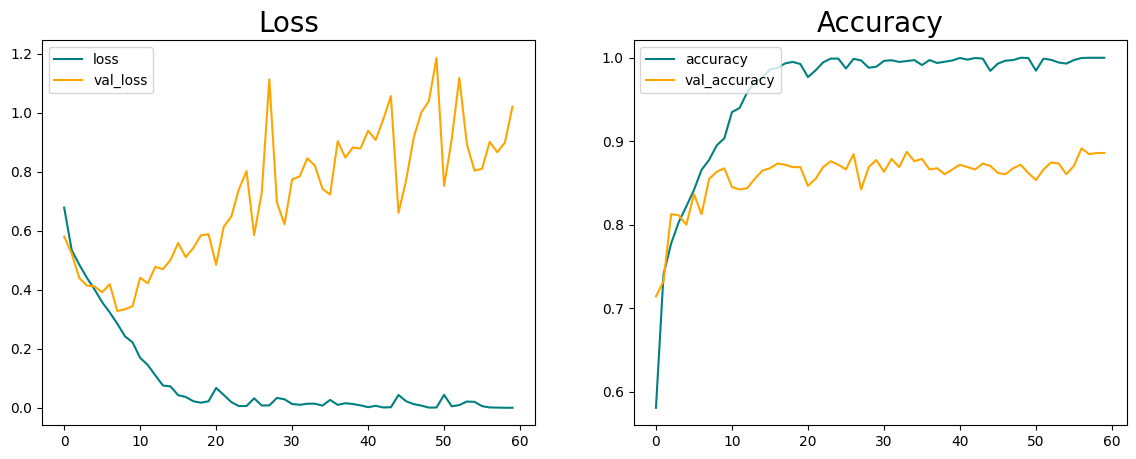

In [48]:
# get the history of the second model (Basic second model, we just add one layer)

hist1 = model1.fit(
    img_train,
    label_train,
    batch_size = 32,
    epochs=60,
    validation_split = 0.15
    )

plot_loss_accuracy(hist1)

In [49]:
# Initialize the model / Model 2 but with L2 and Batch Normalization
model1 = Sequential()

model1.add(Conv2D(16, (3, 3), strides=1, activation='relu', input_shape=(150, 150, 1), kernel_regularizer=l2(0.01)))
model1.add(BatchNormalization())
model1.add(MaxPooling2D())


model1.add(Conv2D(32, (3, 3), strides=1, activation='relu', kernel_regularizer=l2(0.01)))
model1.add(BatchNormalization())
model1.add(MaxPooling2D())


model1.add(Conv2D(64, (3, 3), strides=1, activation='relu', kernel_regularizer=l2(0.01)))
model1.add(BatchNormalization())
model1.add(MaxPooling2D())


model1.add(Conv2D(128, (3, 3), strides=1, activation='relu', kernel_regularizer=l2(0.01)))
model1.add(BatchNormalization())
model1.add(MaxPooling2D())
model1.add(Dropout(0.1))

model1.add(Flatten())
model1.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
model1.add(Dropout(0.5))

model1.add(Dense(1, activation='sigmoid'))

model1.compile(optimizer='adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

model1.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_50 (Conv2D)          (None, 148, 148, 16)      160       
                                                                 
 batch_normalization_19 (Ba  (None, 148, 148, 16)      64        
 tchNormalization)                                               
                                                                 
 max_pooling2d_49 (MaxPooli  (None, 74, 74, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_51 (Conv2D)          (None, 72, 72, 32)        4640      
                                                                 
 batch_normalization_20 (Ba  (None, 72, 72, 32)        128       
 tchNormalization)                                               
                                                     

Epoch 1/60
126/126 [==============================] - 8s 31ms/step - loss: 5.2706 - accuracy: 0.7599 - val_loss: 5.8027 - val_accuracy: 0.5437
Epoch 2/60
126/126 [==============================] - 3s 26ms/step - loss: 2.7064 - accuracy: 0.8282 - val_loss: 3.3944 - val_accuracy: 0.5465
Epoch 3/60
126/126 [==============================] - 3s 27ms/step - loss: 1.7532 - accuracy: 0.8367 - val_loss: 3.6503 - val_accuracy: 0.5451
Epoch 4/60
126/126 [==============================] - 4s 28ms/step - loss: 1.3932 - accuracy: 0.8499 - val_loss: 3.2182 - val_accuracy: 0.5465
Epoch 5/60
126/126 [==============================] - 3s 28ms/step - loss: 1.1723 - accuracy: 0.8561 - val_loss: 1.5856 - val_accuracy: 0.7324
Epoch 6/60
126/126 [==============================] - 3s 27ms/step - loss: 0.9923 - accuracy: 0.8747 - val_loss: 0.9860 - val_accuracy: 0.8563
Epoch 7/60
126/126 [==============================] - 3s 28ms/step - loss: 0.8649 - accuracy: 0.8901 - val_loss: 2.1164 - val_accuracy: 0.5563

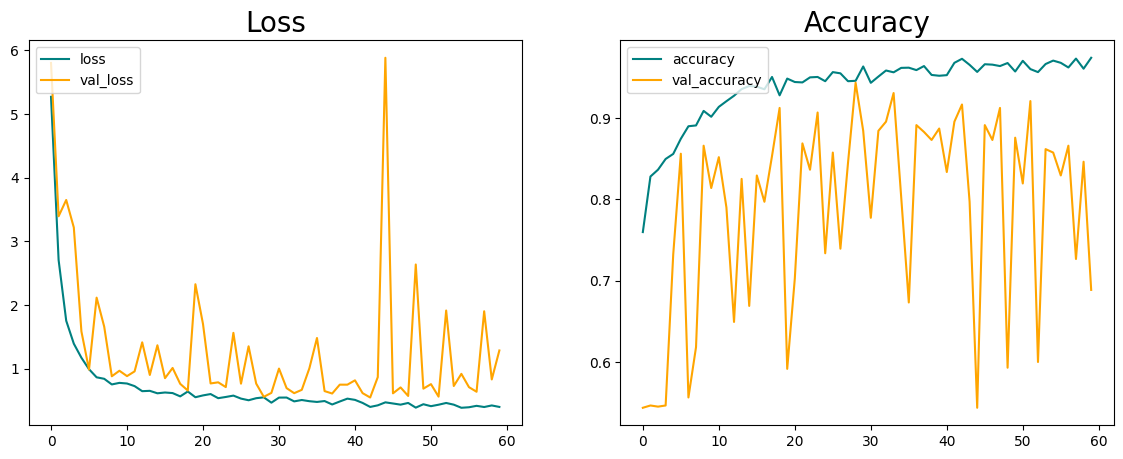

In [50]:
# get the history of the second model

hist1 = model1.fit(
    img_train,
    label_train,
    batch_size = 32,
    epochs=60,
    validation_split = 0.15
    )

plot_loss_accuracy(hist1)

Second model without batch normalization


In [42]:
# Initialize the model
model1_l2 = Sequential()

model1_l2.add(Conv2D(16, (3, 3), strides=1, activation='relu', input_shape=(150, 150, 1), kernel_regularizer=l2(0.01)))
model1_l2.add(MaxPooling2D())


model1_l2.add(Conv2D(32, (3, 3), strides=1, activation='relu', kernel_regularizer=l2(0.01)))
model1_l2.add(MaxPooling2D())


model1_l2.add(Conv2D(64, (3, 3), strides=1, activation='relu', kernel_regularizer=l2(0.01)))
model1_l2.add(MaxPooling2D())


model1_l2.add(Conv2D(128, (3, 3), strides=1, activation='relu', kernel_regularizer=l2(0.01)))
model1_l2.add(MaxPooling2D())


model1_l2.add(Flatten())
model1_l2.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
model1_l2.add(Dropout(0.5))

model1_l2.add(Dense(1, activation='sigmoid'))

model1_l2.compile(optimizer='adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

model1_l2.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_34 (Conv2D)          (None, 148, 148, 16)      160       
                                                                 
 max_pooling2d_33 (MaxPooli  (None, 74, 74, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_35 (Conv2D)          (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_34 (MaxPooli  (None, 36, 36, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_36 (Conv2D)          (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_35 (MaxPooli  (None, 17, 17, 64)      

In [43]:
hist1l2 = model1_l2.fit(
    img_train,
    label_train,
    batch_size = 32,
    epochs=60,
    validation_split = 0.15
    )

plot_loss_accuracy(hist1l2)

Epoch 1/60
126/126 [==============================] - 4s 18ms/step - loss: 1.3067 - accuracy: 0.5444 - val_loss: 0.7003 - val_accuracy: 0.5437
Epoch 2/60
126/126 [==============================] - 2s 14ms/step - loss: 0.6930 - accuracy: 0.5401 - val_loss: 0.6912 - val_accuracy: 0.5437
Epoch 3/60
126/126 [==============================] - 2s 14ms/step - loss: 0.6908 - accuracy: 0.5401 - val_loss: 0.6897 - val_accuracy: 0.5437
Epoch 4/60
126/126 [==============================] - 2s 14ms/step - loss: 0.6905 - accuracy: 0.5401 - val_loss: 0.6895 - val_accuracy: 0.5437
Epoch 5/60
126/126 [==============================] - 2s 16ms/step - loss: 0.6903 - accuracy: 0.5401 - val_loss: 0.6895 - val_accuracy: 0.5437
Epoch 6/60
 13/126 [==>...........................] - ETA: 1s - loss: 0.6901 - accuracy: 0.5457

KeyboardInterrupt: 

Second model without L2 weight decay



In [38]:
# Initialize the model
model1_bn = Sequential()

model1_bn.add(Conv2D(16, (3, 3), strides=1, activation='relu', input_shape=(150, 150, 1)))
model1_bn.add(BatchNormalization())
model1_bn.add(MaxPooling2D())


model1_bn.add(Conv2D(32, (3, 3), strides=1, activation='relu'))
model1_bn.add(BatchNormalization())
model1_bn.add(MaxPooling2D())


model1_bn.add(Conv2D(64, (3, 3), strides=1, activation='relu'))
model1_bn.add(BatchNormalization())
model1_bn.add(MaxPooling2D())


model1_bn.add(Conv2D(128, (3, 3), strides=1, activation='relu'))
model1_bn.add(BatchNormalization())
model1_bn.add(MaxPooling2D())


model1_bn.add(Flatten())
model1_bn.add(Dense(256, activation='relu'))
model1_bn.add(Dropout(0.5))

model1_bn.add(Dense(1, activation='sigmoid'))

model1_bn.compile(optimizer='adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

model1_bn.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 148, 148, 16)      160       
                                                                 
 batch_normalization_7 (Bat  (None, 148, 148, 16)      64        
 chNormalization)                                                
                                                                 
 max_pooling2d_29 (MaxPooli  (None, 74, 74, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_31 (Conv2D)          (None, 72, 72, 32)        4640      
                                                                 
 batch_normalization_8 (Bat  (None, 72, 72, 32)        128       
 chNormalization)                                                
                                                     

Epoch 1/60
126/126 [==============================] - 6s 22ms/step - loss: 0.7903 - accuracy: 0.7472 - val_loss: 3.4867 - val_accuracy: 0.5437
Epoch 2/60
126/126 [==============================] - 2s 20ms/step - loss: 0.3878 - accuracy: 0.8369 - val_loss: 3.6550 - val_accuracy: 0.5437
Epoch 3/60
126/126 [==============================] - 3s 21ms/step - loss: 0.3425 - accuracy: 0.8566 - val_loss: 1.1260 - val_accuracy: 0.5648
Epoch 4/60
126/126 [==============================] - 2s 19ms/step - loss: 0.2725 - accuracy: 0.8824 - val_loss: 2.5688 - val_accuracy: 0.5451
Epoch 5/60
126/126 [==============================] - 2s 18ms/step - loss: 0.2364 - accuracy: 0.9031 - val_loss: 0.3414 - val_accuracy: 0.8634
Epoch 6/60
126/126 [==============================] - 2s 18ms/step - loss: 0.1896 - accuracy: 0.9262 - val_loss: 0.2829 - val_accuracy: 0.8915
Epoch 7/60
126/126 [==============================] - 2s 18ms/step - loss: 0.1498 - accuracy: 0.9421 - val_loss: 0.3274 - val_accuracy: 0.8986

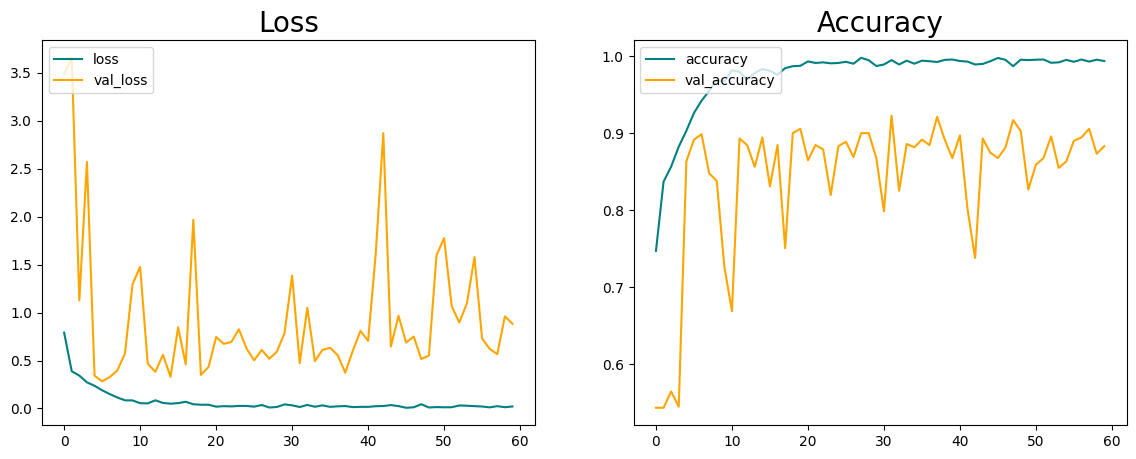

In [39]:
hist1bn = model1_bn.fit(
    img_train,
    label_train,
    batch_size = 32,
    epochs=60,
    validation_split = 0.15
    )

plot_loss_accuracy(hist1bn)

## Save the model
Maybe this can be done after we get the best model, and only for that model


In [40]:
#model.save(os.path.join('models','model1.h5'))
# h5 is a serialization format, like .zip

In [41]:
# "import" the model
#new_model = load_model(os.path.join('models','model1.h5'))